<a href="https://colab.research.google.com/github/dar10p/atmos-optics/blob/FGbranch/Tarea_1_Simulador_Imagen_Felipe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Tarea 1, Simulador de sistema de imagen
Felipe Guzmán

Se importan las librerías necesarias:

*   numpy para cálculos
*   matplotlib para herramientas de gráficos



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import data
from skimage.color import rgb2gray
from skimage.transform import resize
from matplotlib.pyplot import figure

Se genera el objeto $I_g(u,v)$ que corresponde a la irradiancia geometrica perfecta definida en el capítulo 7 del Voelz [Computational fourier optics: A MATLAB tutorial](https://drive.google.com/file/d/1URAoRYjupz7E_ei5rFyL-uzsaPJHpiK9/view). Este corresponde a una imagen natural normalizada por su peso en frecuencia 0. Para este ejempli se utilizó la placa de calibración USAF 1951 con un tamaño de pixel de $2048 \times 2048$.




In [ ]:
size= 2048
im = plt.imread('usaf.jpg')
im = rgb2gray(im)
im = resize(im,[size,size])
Ig = im - np.amin(im)
Ig = Ig/np.amax(Ig)

[M,N] = im.shape

Se definen los siguientes parametros:
*   $L$ es el tamaño del plano de imagen
*   $\Delta u$ corresponde al intervalo de sampleo
*   $(u,v)$ corresponden a los ejes coordenados del plano imagen en $[m]$







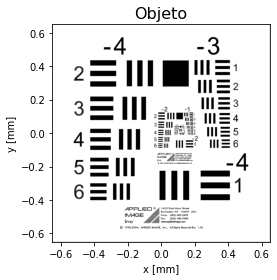

In [ ]:
L = 1.3*10**-3 #Side length
du = L/M
u = np.linspace(-(L/2),(L/2),size)
v = u

plt.imshow(Ig,'gray',extent = [-(L/2)*1000 , (L/2)*1000, -(L/2)*1000, (L/2)*1000])
plt.title('Objeto', fontsize=16)
plt.xlabel('u [mm]')
plt.ylabel('v [mm]')
plt.show()


Para modelar un sistema óptico, se consideran los siguiente parametros
*   $\lambda$: Longitud de onda
*   $z_{ep}$: Distancia de la entrance pupil
*   $z_{xp}$: Distancia de la exit pupil
*   $D_{ep}$: Diametro de la entrance pupil
*   $D_{xp}$: Diametro de la exit pupil
*   $f/\text{#}$: El numero f del lente

Considerando un sistema de lente plano, $z_1=z_{ep}$ y $z_2=z_{xp}$ donde $(z_1,z_2$ son las ditancias de la imagen al lente y lente al plano imagen respectivamente, ademas $D_{ep} = D_{xp} = D_l$ donde $D_l$ corresponde al diametro del lente lo cual es muy conveniente para el diseño ya que se tiene la siguiente expresion $$f/\text{#} = \frac{z_{xp}}{D_{xp}} $$.

Para un sistema de imagen incoherente, la frecuencia de corte determinada por el lente esta determinado por la siguiente ecuacion: $$ f_0 = \frac{w_{xp}}{\lambda z_{xp}}$$






In [ ]:
lamb = 0.5*10**-6

f_number = 10
zxp = 125*10**-3
Dxp = zxp/f_number
wxp = Dxp/2

f0 = wxp/(lamb*zxp)

Con la funcion $\text{circ}\left(\frac{\rho}{f_0}\right)$ se puede generar una mascara circular de radio $f_0$

In [ ]:
def circ(R):
  out = abs(R)<=1
  return out


Se genera los vectores de coordenadas frecuenciales $(f_U,f_V)$

In [ ]:
fu = np.linspace(-(1/(2*du)),(1/(2*du)),size)
fv = fu
Fu, Fv = np.meshgrid(fu,fv,sparse=True)
H = circ(np.sqrt(Fu**2+Fv**2)/f0)


En esta parte se genera la mascara $h(f_U,f_V)$ y con la función $\text{H_to_OTF}$ se realiza la simulacion de la funcion de transferencia óptica $$\mathcal{H}\left(f_{U}, f_{V}\right)=\frac{\mathfrak{I}\left\{\left.h(u, v)\right|^{2}\right\}}{\iint_{-\infty}|h(u, v)|^{2} d u d v}$$

La normalización de $\mathcal{H}$ se realiza con su aporte de frecuencia 0 (DC) con el objetivo de tener un facto de escala de 1 en dicha frecuencia.

In [ ]:
def H_to_OTF(H):
  OTF = np.fft.ifft2(abs(np.fft.fft2(np.fft.fftshift(H)))**2)
  OTF = abs(OTF/OTF[0,0])
  return OTF

Como se observan en las figuras, la pupila simulada para un sistema incoherente tiene una forma conica, mientras que en un sistema coherente es un cilindro, es decir el limite entre las regiones es gradual.

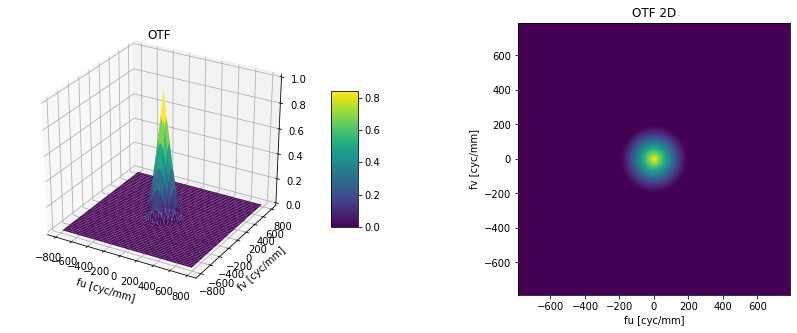

In [ ]:
OTF = H_to_OTF(H)

fig = plt.figure(figsize = (15,5))
ax1 = fig.add_subplot(1,2,1, projection='3d')

surf = ax1.plot_surface(Fu/1000, Fv/1000, np.fft.fftshift(OTF),cmap='viridis', edgecolor='none',linewidth=0)
fig.colorbar(surf, shrink=0.5, aspect=5)
ax1.set_title('OTF')
ax1.set_xlabel('fu [cyc/mm]')
ax1.set_ylabel('fv [cyc/mm]')

ax2 = fig.add_subplot(1,2,2)
plt.imshow(np.fft.fftshift(OTF),extent = [-(1/(2*du))/1000 , (1/(2*du))/1000, -(1/(2*du))/1000, (1/(2*du))/1000]) # transfer function
ax2.set_title('OTF 2D')
ax2.set_xlabel('fu [cyc/mm]')
ax2.set_ylabel('fv [cyc/mm]')
plt.show()


Para obtener la imagen generada en el plano, responde a la siguiente ecuación:
 $$I_{i}(u, v)=\mathfrak{F}^{-1}\left\{\mathcal{H}\left(f_{U}, f_{V}\right) \mathfrak{F}\left\{I_{g}(u, v)\right\}\right\}$$
donde $\mathfrak{F}$ representa la transformada de Fourier

In [ ]:
Gg = np.fft.fft2(np.fft.fftshift(Ig))
Gi = Gg*OTF
Ii = np.fft.ifftshift(np.fft.ifft2(Gi))
Ii = np.real(Ii)
Ii = Ii*(Ii>=0)

Ya que al ser un sistema digital, la transformada de Fourier es una aproximacion lo que proboca que para objetos de magnitud pura, al simular la formacion de imagen, esta tenga residuos de fase por lo que, si se sabe que la fuente es de magnitud, se se utilizan las ultimas dos lineas para eliminar los residuos complejos de la imagen y los elementos negativos.

Text(0, 0.5, 'y [mm]')

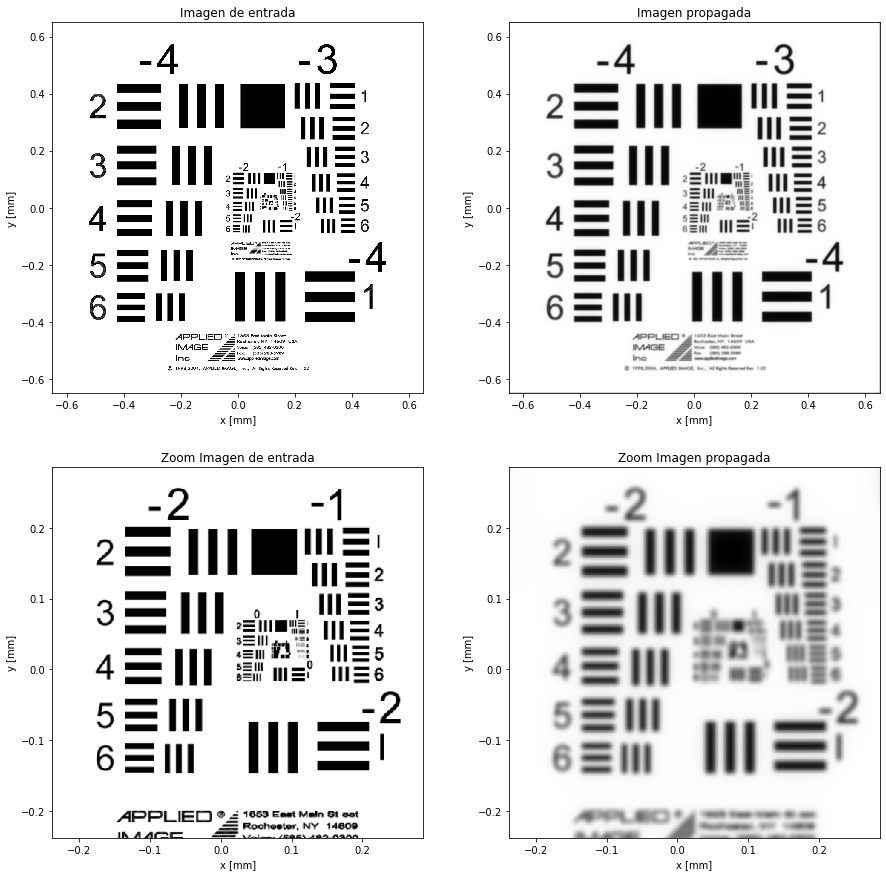

In [ ]:
fig1 = plt.figure(figsize = (15,15)) # create a figure with the default size 

ax1 = fig1.add_subplot(2,2,1) 
ax1.imshow(Ig,'gray' ,interpolation='none',extent = [-(L/2)*1000 , (L/2)*1000, -(L/2)*1000, (L/2)*1000])
ax1.set_title('Imagen de entrada')
ax1.set_xlabel('x [mm]')
ax1.set_ylabel('y [mm]')

ax1 = fig1.add_subplot(2,2,2) 
ax1.imshow(Ii,'gray' , interpolation='none',extent = [-(L/2)*1000 , (L/2)*1000, -(L/2)*1000, (L/2)*1000])
ax1.set_title('Imagen propagada')
ax1.set_xlabel('x [mm]')
ax1.set_ylabel('y [mm]')


ax1 = fig1.add_subplot(2,2,3) 
ax1.imshow(Ig[750:1250,900:1400],'gray' , interpolation='none',extent = [-((750*du)/2)*1000 , ((900*du)/2)*1000, -((750*du)/2)*1000, ((900*du)/2)*1000])
ax1.set_title('Zoom Imagen de entrada')
ax1.set_xlabel('x [mm]')
ax1.set_ylabel('y [mm]')


ax1 = fig1.add_subplot(2,2,4) 
ax1.imshow(Ii[750:1250,900:1400],'gray' , interpolation='none',extent = [-((750*du)/2)*1000 , ((900*du)/2)*1000, -((750*du)/2)*1000, ((900*du)/2)*1000])
ax1.set_title('Zoom Imagen propagada')
ax1.set_xlabel('x [mm]')
ax1.set_ylabel('y [mm]')

En las imagenes se obtiene una comparación de la resolución conseguida por el sistema de imagen, con un zoom en los elementos mas pequeños del target de calibración.